### Importing Modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import pickle
import scipy.io as sio
from basicFunctions.filters import \
                        butter_bandpass_filter,butter_highpass_filter,butter_lowpass_filter
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages

darkMode = False

if darkMode:
        plt.style.use('dark_background')

In [3]:
from mainFunctions.normalizedBetween_0_and_1\
                    import normalizedBetween_0_and_1

In [4]:
%load_ext autoreload
%autoreload 2

### names of the recording sessions

In [9]:
sessionName = ['CW_191110_072941','CW_200213_093607','CW_191207_164403',\
               'CW_200320_132039',\
               'CW_200229_103710','CW_200206_093345','CW_200229_155255',\
               'CW_191113_073032','CW_200206_093029','CW_200213_153602',\
               'CW_200227_093534','CW_200227_095545','CW_200227_124846',\
               'CW_200227_124434','CW_200227_153027','CW_200227_152609'\
               ]

animalType = ['Hz','Hz','Hz',\
              'Hz',\
              'Ht','Ht','Ht',\
              'Ct','Ct','Ct',\
              'Pv-Hz','Pv-Hz','Pv-Hz',\
              'SST-Hz','SST-Hz','SST-Hz']

fsSession = [20e3,20e3,]
fsSession[0]

20000.0

### reading the results of sessions

In [33]:
allWaveShapes = []
allSpikeWidth = []
allSpontFRs = []
allClustersChannel = []
allL5EstimatedChannel = []
allAlertSpontFR = []
allNonAlertSpontFR = []
allTriggeredSpikeTimes = []
allAlertTriggeredSpikeTimes = []
allNonAlertTriggeredSpikeTimes = []
allKS_pval = []
allPairsCrossCorrPeak = []
allPairsCrossCorrPeakAlert = []
allPairsCrossCorrPeakNonAlert = []
allPairsCrossCorrTriggeredSpikeTimesAlert = []
allPairsCrossCorrTriggeredSpikeTimesNonAlert = []
allKS_pval_Alert = []
allKS_pval_NonAlert = []
allSmoothedCrossCorrs = []
allSmoothedCrossCorrsAlert = []
allSmoothedCrossCorrsNonAlert = []
allFacialMovement = []

baseFolderAddress = "Y:\Ehsan-temp\Claire-Ehsan_Share\DataToMerge//"
saveFigFolderAddress = "Y:\Ehsan-temp\Claire-Ehsan_Share\DataToMerge\\figs//"

for sessionLoopCounter in range(10):#len(sessionName)):
    
    dataAddress = baseFolderAddress + sessionName[sessionLoopCounter] + '.pkl'
    
#     print(sessionName[sessionLoopCounter])
    
    pkl_file = open(dataAddress, 'rb')
    SavedData = pickle.load(pkl_file)
    pkl_file.close()
    
    allWaveShapes.append(SavedData[0])
    allSpikeWidth.append(SavedData[1])
    allSpontFRs.append(SavedData[2])
    allClustersChannel.append(SavedData[3])
    allL5EstimatedChannel.append(SavedData[30])
    allAlertSpontFR.append(SavedData[28])
    allNonAlertSpontFR.append(SavedData[29])
    allPairsCrossCorrPeak.append(SavedData[32])
    allPairsCrossCorrPeakAlert.append(SavedData[36])
    allPairsCrossCorrTriggeredSpikeTimesAlert.append(SavedData[35])
    allPairsCrossCorrTriggeredSpikeTimesNonAlert.append(SavedData[39])
    allPairsCrossCorrPeakNonAlert.append(SavedData[40])
    allKS_pval.append(SavedData[43])
    allAlertTriggeredSpikeTimes.append(SavedData[35])
    allNonAlertTriggeredSpikeTimes.append(SavedData[39])
    allKS_pval_Alert.append(SavedData[45])
    allKS_pval_NonAlert.append(SavedData[46])
    allSmoothedCrossCorrs.append(SavedData[34])
    allFacialMovement.append(SavedData[44])
    
uniqueAnimalTypes = np.unique(animalType)
crossCorrWindowLength = np.concatenate(allSmoothedCrossCorrs).shape[1]

In [25]:
np.unique(animalType)

array(['Ct', 'Ht', 'Hz', 'Pv-Hz', 'SST-Hz'], dtype='<U6')

### distribution of all spike width

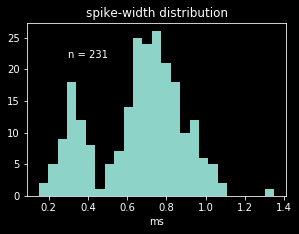

In [270]:
mergedSpikeWidth = np.concatenate(allSpikeWidth)

figWidthDist = plt.figure(figsize=(6,4))
axWidthDist = figWidthDist.add_axes([0.2,0.2,0.6,0.6])
axWidthDist.hist(mergedSpikeWidth,bins=25);
axWidthDist.set_xlabel('ms')
axWidthDist.set_title('spike-width distribution')
axWidthDist.text(0.3,axWidthDist.get_ylim()[1]*0.8,'n = %(number)d'%{'number':len(mergedSpikeWidth)});

fileNameToSave = 'spikeWidthDistribution.pdf'
figWidthDist.savefig( saveFigFolderAddress+ fileNameToSave, \
                      dpi=200, transparent=False)

In [75]:
narrowSpikingCutLevel = 0.4
wideSpikingCutLevel = 0.6

narrowSpikingColor = '#CA4156'
wideSpikingColor = '#15566D'

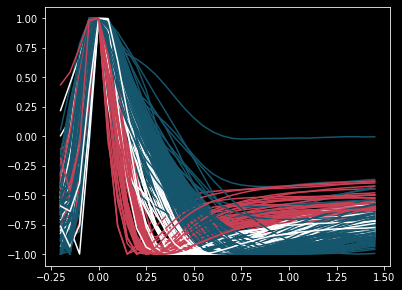

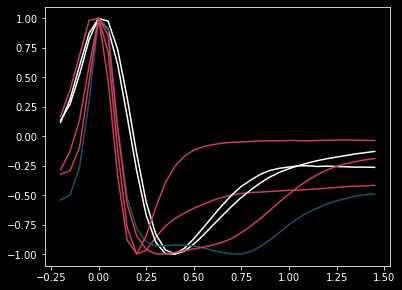

In [250]:
fs = 20e3

normSpikeWindowBeforeTime = 0.2 #in ms
normSpikeWindowAfterTime = 1.5 #in ms

repolarizationTime = 0.6 #in ms
repolarizationSample = int(repolarizationTime*fs/1e3)

negativeSpikesRepolarizationValues = []
negativeSpikesWidth = []
# allColors = []

normSpikeWindowBeforeSample = int(normSpikeWindowBeforeTime*fs/1e3) #in ms
normSpikeWindowAfterSample = int(normSpikeWindowAfterTime*fs/1e3) #in ms

mergedSpikeWaveShapes = np.concatenate(allWaveShapes)

figAllSpikesWaveShapes = plt.figure(figsize=(8,6))
axAllSpikesWaveShapes = figAllSpikesWaveShapes.add_axes([0.2,0.2,0.6,0.6])

figPositiveSpikesWaveShapes = plt.figure(figsize=(8,6))
axPositiveSpikesWaveShapes = figPositiveSpikesWaveShapes.add_axes([0.2,0.2,0.6,0.6])

for neuronLoopCounter in range(len(mergedSpikeWidth)):
    
    
    # if negative spike
    if abs(min(mergedSpikeWaveShapes[neuronLoopCounter])) >\
                    abs(max(mergedSpikeWaveShapes[neuronLoopCounter])):
    
        normalizedWaveShape =  1 - normalizedBetween_0_and_1(mergedSpikeWaveShapes[neuronLoopCounter])*2
        
    else: #Positive Spike
        normalizedWaveShape =  normalizedBetween_0_and_1(mergedSpikeWaveShapes[neuronLoopCounter])*2 - 1

    spikePeakSample = np.argmax(normalizedWaveShape)
    repolarizationValue = normalizedWaveShape[spikePeakSample+repolarizationSample]
    
    plotAlphaVal = 1
    if mergedSpikeWidth[neuronLoopCounter] < narrowSpikingCutLevel:
        waveShapeColor = narrowSpikingColor
    elif mergedSpikeWidth[neuronLoopCounter] > wideSpikingCutLevel:
        waveShapeColor = wideSpikingColor
    else:
        waveShapeColor = 'w'
        plotAlphaVal = 1
        
#     plt.figure()
    if abs(min(mergedSpikeWaveShapes[neuronLoopCounter])) >\
                    abs(max(mergedSpikeWaveShapes[neuronLoopCounter])):
        axAllSpikesWaveShapes.plot(np.arange(-normSpikeWindowBeforeTime,normSpikeWindowAfterTime,1e3/fs),\
                           normalizedWaveShape[spikePeakSample-normSpikeWindowBeforeSample:\
                                    spikePeakSample+normSpikeWindowAfterSample],c=waveShapeColor,
                                  alpha = plotAlphaVal)
        
        negativeSpikesRepolarizationValues.append(repolarizationValue)
        negativeSpikesWidth.append(mergedSpikeWidth[neuronLoopCounter])
        
    else:
        axPositiveSpikesWaveShapes.plot(np.arange(-normSpikeWindowBeforeTime,normSpikeWindowAfterTime,1e3/fs),\
                                   normalizedWaveShape[spikePeakSample-normSpikeWindowBeforeSample:\
                                            spikePeakSample+normSpikeWindowAfterSample],c=waveShapeColor)

    
#     print(repolarizationValue)

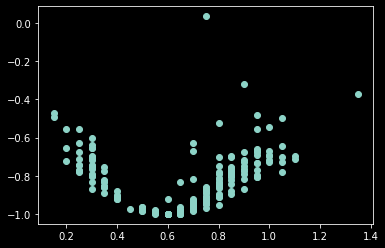

In [76]:
plt.plot(negativeSpikesWidth,negativeSpikesRepolarizationValues,'o')

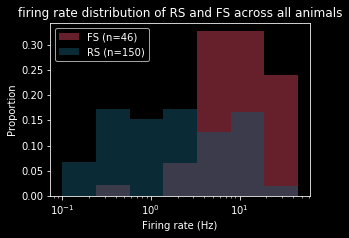

In [275]:
narrowSpikingCutLevel = 0.4
wideSpikingCutLevel = 0.6
# binWidth = 1

narrowSpikingFRs = np.concatenate(allSpontFRs)[np.where(mergedSpikeWidth < narrowSpikingCutLevel)]
wideSpikingFRs = np.concatenate(allSpontFRs)[np.where(mergedSpikeWidth > wideSpikingCutLevel)]

minFR = 0.1
maxFR = max(max(narrowSpikingFRs),max(wideSpikingFRs))
bins = 8

narrowSpikingCellNo = len(np.where(mergedSpikeWidth < narrowSpikingCutLevel)[0])
wideSpikingCellNo = len(np.where(mergedSpikeWidth > wideSpikingCutLevel)[0])

figFRdist = plt.figure(figsize=(6,4))
axFRdist = figFRdist.add_axes([0.2,0.2,0.6,0.6])

weights = np.ones_like(narrowSpikingFRs)/float(len(narrowSpikingFRs))
axFRdist.hist(narrowSpikingFRs,weights=weights\
         ,alpha=0.5,bins=np.logspace(np.log10(minFR),np.log10(maxFR), bins),color=narrowSpikingColor)



weights = np.ones_like(wideSpikingFRs)/float(len(wideSpikingFRs))
x, bins, p=plt.hist(wideSpikingFRs,weights=weights\
        ,alpha=0.5,bins=np.logspace(np.log10(minFR),np.log10(maxFR), bins),color=wideSpikingColor);


axFRdist.legend(['FS (n=%(FS_cellNumber)d)'%{'FS_cellNumber':narrowSpikingCellNo},\
            'RS (n=%(RS_cellNumber)d)'%{'RS_cellNumber':wideSpikingCellNo}],loc='upper left')

axFRdist.set_xscale('log')
axFRdist.set_title('firing rate distribution of RS and FS across all animals');
axFRdist.set_xlabel('Firing rate (Hz)')
axFRdist.set_ylabel('Proportion')


fileNameToSave = 'FR_distribution_AllCells.pdf'
figFRdist.savefig( saveFigFolderAddress+ fileNameToSave, \
                      dpi=200, transparent=False)

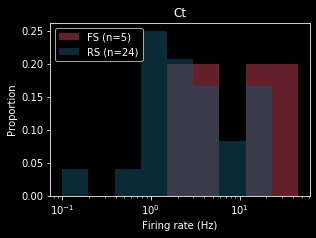

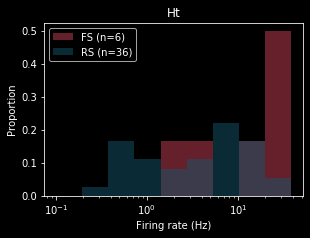

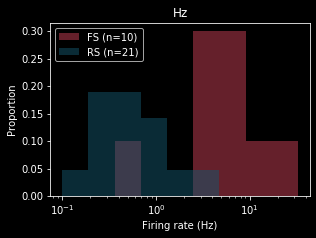

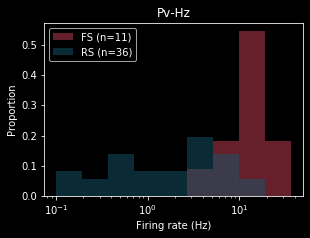

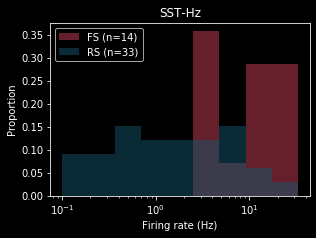

In [277]:

allnarrowSpikesFR = []
allwideSpikesFR = []
for animalTypeLoopID in uniqueAnimalTypes:
    
    animalTypeIndices = np.where(np.array(animalType)==animalTypeLoopID)[0]
    
    animalTypeSpontFR = np.concatenate(list(allSpontFRs[itemPos] for itemPos in animalTypeIndices))
    
    animalTypeSpikeWidth = np.concatenate(list(allSpikeWidth[itemPos] for itemPos in animalTypeIndices))
        
    narrowSpikingFRs = animalTypeSpontFR[np.where(animalTypeSpikeWidth < narrowSpikingCutLevel)]
    wideSpikingFRs = animalTypeSpontFR[np.where(animalTypeSpikeWidth > wideSpikingCutLevel)]
    
    allnarrowSpikesFR.append(narrowSpikingFRs)
    allwideSpikesFR.append(wideSpikingFRs)

    minFR = 0.1
    maxFR = max(max(narrowSpikingFRs),max(wideSpikingFRs))
    bins = 10
    
    narrowSpikingCellNo = len(np.where(animalTypeSpikeWidth < narrowSpikingCutLevel)[0])
    wideSpikingCellNo = len(np.where(animalTypeSpikeWidth > wideSpikingCutLevel)[0])

    figFRdist = plt.figure(figsize=(6,4))
    axFRdist = figFRdist.add_axes([0.2,0.2,0.6,0.6])

    weights = np.ones_like(narrowSpikingFRs)/float(len(narrowSpikingFRs))
    axFRdist.hist(narrowSpikingFRs,weights=weights\
             ,alpha=0.5,bins=np.logspace(np.log10(minFR),np.log10(maxFR), bins),color=narrowSpikingColor)



    weights = np.ones_like(wideSpikingFRs)/float(len(wideSpikingFRs))
    x, bins, p=plt.hist(wideSpikingFRs,weights=weights\
            ,alpha=0.5,bins=np.logspace(np.log10(minFR),np.log10(maxFR), bins),color=wideSpikingColor);


    axFRdist.legend(['FS (n=%(FS_cellNumber)d)'%{'FS_cellNumber':narrowSpikingCellNo},\
                'RS (n=%(RS_cellNumber)d)'%{'RS_cellNumber':wideSpikingCellNo}],loc='upper left')

    axFRdist.set_xscale('log')
    plt.title(animalTypeLoopID)
    plt.xlabel('Firing rate (Hz)')
    plt.ylabel('Proportion')
    
    fileNameToSave = animalTypeLoopID + '_FR_distribution.pdf'
    figFRdist.savefig( saveFigFolderAddress+ fileNameToSave, \
                          dpi=200, transparent=False)
    

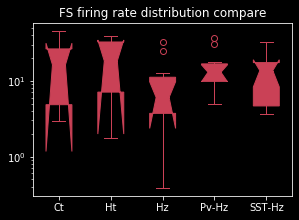

In [296]:
c=narrowSpikingColor
figNarrowSpikingFRCompare = plt.figure(figsize=(6,4))
axNarrowSpikingFRCompare = figNarrowSpikingFRCompare.add_axes([0.2,0.2,0.6,0.6])
axNarrowSpikingFRCompare.boxplot(allnarrowSpikesFR,notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            );
axNarrowSpikingFRCompare.set_xticklabels(uniqueAnimalTypes)
axNarrowSpikingFRCompare.set_yscale('log')
axNarrowSpikingFRCompare.set_title('FS firing rate distribution compare')

fileNameToSave = 'FS_FRdistributionCompare.pdf'
figNarrowSpikingFRCompare.savefig( saveFigFolderAddress+ fileNameToSave, \
                      dpi=200, transparent=False)

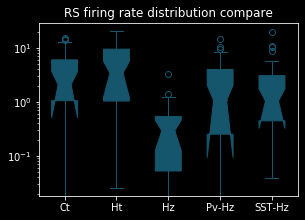

In [299]:
c=wideSpikingColor
figWideSpikingFRCompare = plt.figure(figsize=(6,4))
axWideSpikingFRCompare = figWideSpikingFRCompare.add_axes([0.2,0.2,0.6,0.6])
axWideSpikingFRCompare.boxplot(allwideSpikesFR,notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            );
axWideSpikingFRCompare.set_xticklabels(uniqueAnimalTypes)
axWideSpikingFRCompare.set_yscale('log')
axWideSpikingFRCompare.set_title('RS firing rate distribution compare')

fileNameToSave = 'RS_FRdistributionCompare.pdf'
figWideSpikingFRCompare.savefig( saveFigFolderAddress+ fileNameToSave, \
                      dpi=200, transparent=False)

### cell types across layers

In [514]:
narrowSpikingCutLevel = 0.4
wideSpikingCutLevel = 0.6

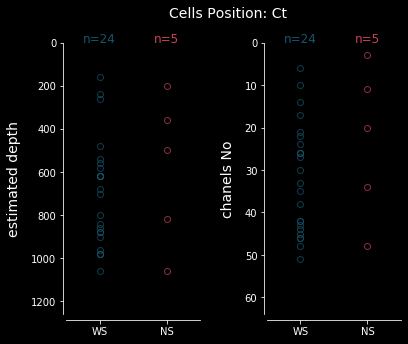

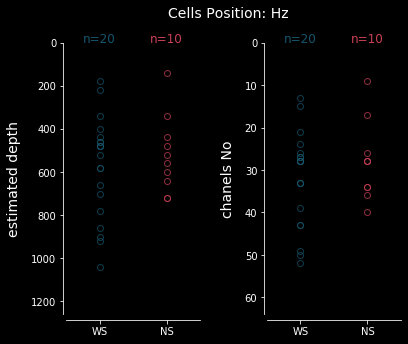

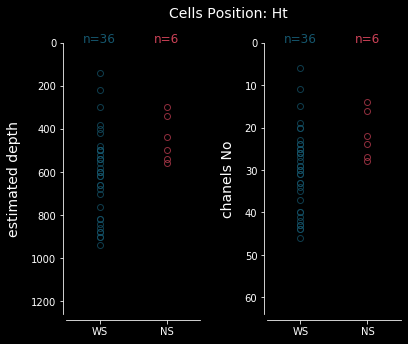

In [512]:
L5_estimatedDepth = 600 # in micro meter
recordingSitesDistance = 20

# sessionCounter = 1
# animalTypeLoopID = 'Ct'
for animalTypeLoopID in ['Ct','Hz','Ht']:#uniqueAnimalTypes:
    
    animalTypeIndices = np.where(np.array(animalType)==animalTypeLoopID)[0]
    
    figCellsPos, (axCellsPos, axCellsChann) = plt.subplots(1,2,figsize=(6,5))
    
    figCellsPos.suptitle("Cells Position: " + animalTypeLoopID, fontsize=14)
    
    figCellsPos.subplots_adjust(wspace=0.5)
#     axCellsPos = figCellsPos.add_axes([0.2,0.2,0.6,0.6])

    WS_cellNo = 0
    NS_cellNo = 0
    
    for sessionCounter in animalTypeIndices:
        WS = list(np.where(np.array(allSpikeWidth[sessionCounter])>wideSpikingCutLevel)[0])
        WS_depth = L5_estimatedDepth - recordingSitesDistance*\
                    (allL5EstimatedChannel[sessionCounter] - \
                     np.array(allClustersChannel[sessionCounter])[WS])

        axCellsPos.plot(np.ones(len(WS_depth)),WS_depth,'o',fillstyle='none',\
                        alpha=0.7,color=wideSpikingColor)
        
        axCellsChann.plot(np.ones(len(WS_depth)),np.array(allClustersChannel[sessionCounter])[WS]\
                        ,'o',fillstyle='none',\
                        alpha=0.7,color=wideSpikingColor)
        
        WS_cellNo = WS_cellNo + len(WS)
        
        NS = list(np.where(np.array(allSpikeWidth[sessionCounter])<narrowSpikingCutLevel)[0])
        NS_depth = L5_estimatedDepth - recordingSitesDistance*\
                    (allL5EstimatedChannel[sessionCounter] - \
                     np.array(allClustersChannel[sessionCounter])[NS])

        axCellsPos.plot(np.ones(len(NS_depth))*2,NS_depth,'o',fillstyle='none',\
                        alpha=0.7,color=narrowSpikingColor)
        
        axCellsChann.plot(np.ones(len(NS_depth))*2,np.array(allClustersChannel[sessionCounter])[NS]\
                        ,'o',fillstyle='none',\
                        alpha=0.7,color=narrowSpikingColor)
        
        NS_cellNo = NS_cellNo + len(NS)
    
    
    axCellsPos.set_ylim(bottom=0,top=63*20)
    axCellsPos.invert_yaxis()

    axCellsPos.set_ylabel('estimated depth',fontsize=14,labelpad=10)

    axCellsPos.set_xlim([0.5,2.5])
    axCellsPos.set_xticks([1,2])
    axCellsPos.set_xticklabels(['WS','NS'])

    axCellsPos.spines['right'].set_visible(False)
    axCellsPos.spines['top'].set_visible(False)
    axCellsPos.spines['left'].set_position(('axes', -0.02))
    axCellsPos.spines['bottom'].set_position(('axes', -0.02))
    
    axCellsPos.text(1,0,'n=%(number)d'%{'number':WS_cellNo},color=wideSpikingColor,fontsize=12,ha='center')
    axCellsPos.text(2,0,'n=%(number)d'%{'number':NS_cellNo},color=narrowSpikingColor,fontsize=12,ha='center')
    
    axCellsChann.set_ylim(bottom=0,top=64)
    axCellsChann.invert_yaxis()

    axCellsChann.set_ylabel('chanels No',fontsize=14,labelpad=10)

    axCellsChann.set_xlim([0.5,2.5])
    axCellsChann.set_xticks([1,2])
    axCellsChann.set_xticklabels(['WS','NS'])

    axCellsChann.spines['right'].set_visible(False)
    axCellsChann.spines['top'].set_visible(False)
    axCellsChann.spines['left'].set_position(('axes', -0.02))
    axCellsChann.spines['bottom'].set_position(('axes', -0.02))
    
    axCellsChann.text(1,0,'n=%(number)d'%{'number':WS_cellNo},color=wideSpikingColor,fontsize=12,ha='center')
    axCellsChann.text(2,0,'n=%(number)d'%{'number':NS_cellNo},color=narrowSpikingColor,fontsize=12,ha='center')

## cross-correlogram compare

#### grouping the significant pairwise correlation magnitudes across animal types

In [548]:
# Here we put together the significant pairwise correlation heights to compare different animal types

# setting the significance level to include the pairs with meaningful correlated activity for comparisons
KS_significanceLevel = 1e-5

# the chance level which is based on the width of the window to estimate the correlated activity
# since the chance level is actually the height of the uniform distribution in case two neurons are not
# correlated
chanceLevel = 1/crossCorrWindowLength

# variable to keep the crossCorr peaks of the different groups
# Ws: wide spiking, Ns: Narrow spiking
Ws_Ws_crossPeak_AllGroups = []
Ws_Ns_crossPeak_AllGroups = []
Ns_Ns_crossPeak_AllGroups = []

# keeping the total number of the pairs in each group
Ws_Ws_pairNo_AllGroups = []
Ws_Ns_pairNo_AllGroups = []
Ns_Ns_pairNo_AllGroups = []

# variables to keep the change in the peak of the cross corrs with arousal (or movement?)
Ws_Ws_crossPaekChangeByArousal_AllGroups = []
Ws_Ns_crossPaekChangeByArousal_AllGroups = []
Ns_Ns_crossPaekChangeByArousal_AllGroups = []

# in each iteration of this loop, we gather the info about one group of animals
for animalTypeLoopID in ['Ct','Hz','Ht']:#uniqueAnimalTypes:
    
    # indices of the session regarding this group of the animals
    animalTypeIndices = np.where(np.array(animalType)==animalTypeLoopID)[0]

    figCrossCompare.subplots_adjust(wspace=0.5)

    # temp variables for this group of animals
    Ws_Ws_pairNo = 0
    Ws_Ns_pairNo = 0
    Ns_Ns_pairNo = 0

    # nonSigWsWsPairsNo = 0
    # nonSigWsNsPairsN0 = 0
    # nonSigNsNsPairsNo = 0

    Ws_Ws_crossPeak = []
    Ws_Ns_crossPeak = []
    Ns_Ns_crossPeak = []

    Ws_Ws_crossDelay = []
    Ws_Ns_crossDelay = []
    Ns_Ns_crossDelay = []

    Ws_Ws_crossPaekChangeByArousal = []
    Ws_Ns_crossPaekChangeByArousal = []
    Ns_Ns_crossPaekChangeByArousal = []

    # in each iteration of this loop we extract the info from one session
    for sessionCounter in animalTypeIndices:
        # extracting the indices of the wide-spiking neurons
        WS = list(np.where(np.array(allSpikeWidth[sessionCounter])>wideSpikingCutLevel)[0])
        
        # extracting the indices of the narrow-spiking neurons
        NS = list(np.where(np.array(allSpikeWidth[sessionCounter])<narrowSpikingCutLevel)[0])

        # in each iteration of this loop we extract the info for one pair of wide spiking neurons
        for WS_cellCounter1 in range(len(WS)-1):
            for WS_cellCounter2 in range(WS_cellCounter1+1,len(WS)):

                WS1_cellNo = WS[WS_cellCounter1] #cell number of the first cell
                WS2_cellNo = WS[WS_cellCounter2] #cell number of the second cell

                # counting the total number of the ws-ws pairs
                Ws_Ws_pairNo = Ws_Ws_pairNo + 1

                # just adding a pair that has significant pattern
                if allKS_pval[sessionCounter][WS1_cellNo,WS2_cellNo] < KS_significanceLevel:
                    Ws_Ws_crossPeak.append(allPairsCrossCorrPeak[sessionCounter][WS1_cellNo,WS2_cellNo])
                    
                # Here we calculate the change in correlation of each pair between movement and stillness
                if len(allPairsCrossCorrPeakAlert[sessionCounter]): #to skip the sessions without valid camera data

                    # we just keep the pair for this comparison if one of the two correlation patterns
                    # (correlation during movement or correlation during stillness) is significant
                    if min(allKS_pval_Alert[sessionCounter][WS1_cellNo,WS2_cellNo],\
                          allKS_pval_NonAlert[sessionCounter][WS1_cellNo,WS2_cellNo]) < KS_significanceLevel:
                        
                        # extracting the correlation pattern peak for the movement
                        alertPeakValue = allPairsCrossCorrPeakAlert[sessionCounter][WS1_cellNo,WS2_cellNo]
                        # extracting the correlation pattern peak for the stillness
                        nonAlertPeakValue = \
                                        allPairsCrossCorrPeakNonAlert[sessionCounter][WS1_cellNo,WS2_cellNo]
                        
                        # if either of the correlation patterns during movement or stillness is not 
                        # significant then the peak value for it is replace with the chance level
                        # since the saved value is the distance from the chance level then this value for
                        # the peak here is set to 0
                        if allKS_pval_Alert[sessionCounter][WS1_cellNo,WS2_cellNo] > KS_significanceLevel:
                            alertPeakValue = 0
                        if allKS_pval_NonAlert[sessionCounter][WS1_cellNo,WS2_cellNo] > KS_significanceLevel:
                            nonAlertPeakValue = 0

                        Ws_Ws_crossPaekChangeByArousal.append(alertPeakValue - nonAlertPeakValue)
        # 
        # the same procedure as above but for a pair of narrow spiking neurons
        for NS_cellCounter1 in range(len(NS)-1):
            for NS_cellCounter2 in range(NS_cellCounter1+1,len(NS)):

                NS1_cellNo = NS[NS_cellCounter1]
                NS2_cellNo = NS[NS_cellCounter2]

                Ns_Ns_pairNo = Ns_Ns_pairNo + 1
                
                if allKS_pval[sessionCounter][NS1_cellNo,NS2_cellNo] < KS_significanceLevel:
                    Ns_Ns_crossPeak.append(allPairsCrossCorrPeak[sessionCounter][NS1_cellNo,NS2_cellNo])
                    
                if len(allPairsCrossCorrPeakAlert[sessionCounter]): #to skip the sessions without valid camera data

                    if min(allKS_pval_Alert[sessionCounter][NS1_cellNo,NS2_cellNo],\
                          allKS_pval_NonAlert[sessionCounter][NS1_cellNo,NS2_cellNo]) < KS_significanceLevel:
                        
                        alertPeakValue = allPairsCrossCorrPeakAlert[sessionCounter]\
                                                                        [NS1_cellNo,NS2_cellNo]
                        nonAlertPeakValue = allPairsCrossCorrPeakNonAlert[sessionCounter]\
                                                                        [NS1_cellNo,NS2_cellNo]
                        
                        if allKS_pval_Alert[sessionCounter][NS1_cellNo,NS2_cellNo] > KS_significanceLevel:
                            alertPeakValue = 0
                        if allKS_pval_NonAlert[sessionCounter][NS1_cellNo,NS2_cellNo] > KS_significanceLevel:
                            nonAlertPeakValue = 0

                        Ns_Ns_crossPaekChangeByArousal.append(alertPeakValue - nonAlertPeakValue)


        # the same procdure as above but for a pair of one narrow and one wide spiking neurons
        for WS_cellCounter in range(len(WS)):
            for NS_cellCounter in range(len(NS)):

                WS_cellNo = WS[WS_cellCounter]
                NS_cellNo = NS[NS_cellCounter]

                Ws_Ns_pairNo = Ws_Ns_pairNo + 1

                if allKS_pval[sessionCounter][WS_cellNo,NS_cellNo] < KS_significanceLevel:
                    Ws_Ns_crossPeak.append(allPairsCrossCorrPeak[sessionCounter][WS_cellNo,NS_cellNo])
                    
                if len(allPairsCrossCorrPeakAlert[sessionCounter]): #to skip the sessions without valid camera data

                    if min(allKS_pval_Alert[sessionCounter][WS_cellNo,NS_cellNo],\
                          allKS_pval_NonAlert[sessionCounter][WS_cellNo,NS_cellNo]) < KS_significanceLevel:
                        
                        alertPeakValue = allPairsCrossCorrPeakAlert[sessionCounter]\
                                                                        [WS_cellNo,NS_cellNo]
                        nonAlertPeakValue = allPairsCrossCorrPeakNonAlert[sessionCounter]\
                                                                        [WS_cellNo,NS_cellNo]
                        
                        if allKS_pval_Alert[sessionCounter][WS_cellNo,NS_cellNo] > KS_significanceLevel:
                            alertPeakValue = 0
                        if allKS_pval_NonAlert[sessionCounter][WS_cellNo,NS_cellNo] > KS_significanceLevel:
                            nonAlertPeakValue = 0

                        Ws_Ns_crossPaekChangeByArousal.append(alertPeakValue - nonAlertPeakValue)

    # adding the saved info for this group to the general variable that is kept for all animals
    Ws_Ws_crossPeak_AllGroups.append(Ws_Ws_crossPeak)
    Ws_Ns_crossPeak_AllGroups.append(Ws_Ns_crossPeak)
    Ns_Ns_crossPeak_AllGroups.append(Ns_Ns_crossPeak)
    
    Ws_Ws_pairNo_AllGroups.append(Ws_Ws_pairNo)
    Ws_Ns_pairNo_AllGroups.append(Ws_Ns_pairNo)
    Ns_Ns_pairNo_AllGroups.append(Ns_Ns_pairNo)
    
    Ws_Ws_crossPaekChangeByArousal_AllGroups.append(Ws_Ws_crossPaekChangeByArousal)
    Ws_Ns_crossPaekChangeByArousal_AllGroups.append(Ws_Ns_crossPaekChangeByArousal)
    Ns_Ns_crossPaekChangeByArousal_AllGroups.append(Ns_Ns_crossPaekChangeByArousal)

#### plotting the peak cross corrs for all groups and all different kinds of pairs of neurons

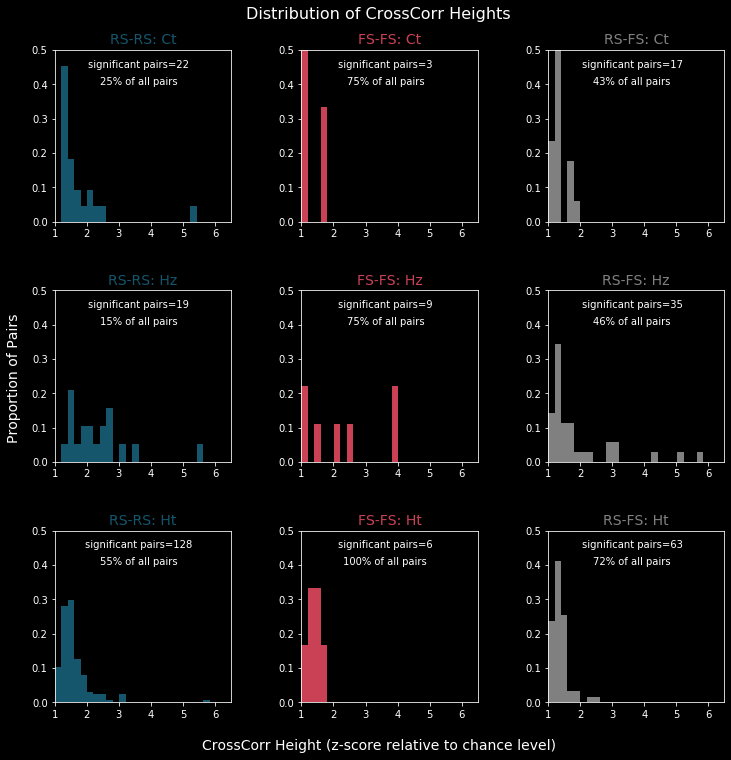

In [557]:

yMaxLim = 0.7

figCrossCompare, axCrossCorrHists = plt.subplots(3,3,figsize=(12,12))
figCrossCompare.subplots_adjust(wspace=0.4,hspace=0.4)
figCrossCompare.suptitle("Distribution of CrossCorr Heights", fontsize=16, y=0.93 )

# to keep all the plots with the same axis length, here we extract the maximum for the x axis of the 
# histograms
xMaxLim = max(np.concatenate((np.concatenate(Ws_Ws_crossPeak_AllGroups),\
                              np.concatenate(Ns_Ns_crossPeak_AllGroups),\
                              np.concatenate(Ws_Ns_crossPeak_AllGroups))))/chanceLevel

# the mimimum for the histogram range is set to 1, because x-axis is normalized to the chance level
# and the hieght is starting from the chance level
xMinLim = 1

# the duration of the range of the histograms
histRangeDur = xMaxLim - xMinLim

histBinSize = 0.2 # the binsize of the histograms
binsNo = int(histRangeDur/histBinSize) # the number of bins of the histograms

figCrossCompare.text(0.5, 0.07, 'CrossCorr Height (z-score relative to chance level)', ha='center',\
                                                        fontsize=14)
figCrossCompare.text(0.07, 0.5, 'Proportion of Pairs', va='center', rotation='vertical',fontsize=14)

groupCounter = 0
# in each iteration one animal type is plotted
for animalTypeLoopID in ['Ct','Hz','Ht']:#uniqueAnimalTypes:
    
    Ws_Ws_crossPeak = Ws_Ws_crossPeak_AllGroups[groupCounter]
    Ws_Ns_crossPeak = Ws_Ns_crossPeak_AllGroups[groupCounter]
    Ns_Ns_crossPeak = Ns_Ns_crossPeak_AllGroups[groupCounter]
    
    Ws_Ws_pairNo = Ws_Ws_pairNo_AllGroups[groupCounter]
    Ws_Ns_pairNo = Ws_Ns_pairNo_AllGroups[groupCounter]
    Ns_Ns_pairNo = Ns_Ns_pairNo_AllGroups[groupCounter]
    
    axWsWs = axCrossCorrHists[groupCounter,0]
    axNsNs = axCrossCorrHists[groupCounter,1]
    axWsNs = axCrossCorrHists[groupCounter,2]
    
    groupCounter = groupCounter + 1
    
    # we use weight to make the histogram y axis being the proportion of the pairs
    axWsWs.hist((np.array(Ws_Ws_crossPeak)/chanceLevel)+1,color=wideSpikingColor\
                ,weights=np.ones(len(Ws_Ws_crossPeak)) / len(Ws_Ws_crossPeak)\
               ,bins=binsNo,range=(xMinLim,xMaxLim));
    axNsNs.hist((np.array(Ns_Ns_crossPeak)/chanceLevel)+1,color=narrowSpikingColor\
               ,weights=np.ones(len(Ns_Ns_crossPeak)) / len(Ns_Ns_crossPeak)\
               ,bins=binsNo,range=(xMinLim,xMaxLim));
    axWsNs.hist((np.array(Ws_Ns_crossPeak)/chanceLevel)+1,color='grey'\
               ,weights=np.ones(len(Ws_Ns_crossPeak)) / len(Ws_Ns_crossPeak)\
               ,bins=binsNo,range=(xMinLim,xMaxLim));
    
#     yMaxLim = max(axWsWs.get_ylim()[1],axWsNs.get_ylim()[1],axNsNs.get_ylim()[1])
    
    axWsWs.set_ylim(top=yMaxLim)
    axWsNs.set_ylim(top=yMaxLim)
    axNsNs.set_ylim(top=yMaxLim)
    
#     xMaxLim = max(axWsWs.get_xlim()[1],axWsNs.get_xlim()[1],axNsNs.get_xlim()[1])
    
    axWsWs.set_xlim(left=xMinLim)
    axWsNs.set_xlim(left=xMinLim)
    axNsNs.set_xlim(left=xMinLim)
    
    axWsWs.set_xticks(range(xMinLim,int(xMaxLim)+1))
    axWsNs.set_xticks(range(xMinLim,int(xMaxLim)+1))
    axNsNs.set_xticks(range(xMinLim,int(xMaxLim)+1))
    
    axWsWs.set_title('RS-RS: '+animalTypeLoopID,color=wideSpikingColor,fontsize=14)
    axNsNs.set_title('FS-FS: '+animalTypeLoopID,color=narrowSpikingColor,fontsize=14)
    axWsNs.set_title('RS-FS: '+animalTypeLoopID,color='grey',fontsize=14)
    
    # writing the number of pairs inside the histogram
    axWsWs.text((xMaxLim+xMinLim)/2,0.9*yMaxLim,'significant pairs=%(number)d'%{'number':len(Ws_Ws_crossPeak)},ha='center')
    axNsNs.text((xMaxLim+xMinLim)/2,0.9*yMaxLim,'significant pairs=%(number)d'%{'number':len(Ns_Ns_crossPeak)},ha='center')
    axWsNs.text((xMaxLim+xMinLim)/2,0.9*yMaxLim,'significant pairs=%(number)d'%{'number':len(Ws_Ns_crossPeak)},ha='center')
    
    # writing the proportion of the pairs that are significant and were included in the histogram
    axWsWs.text((xMaxLim+xMinLim)/2,0.8*yMaxLim,'%(number)d%% of all pairs'%{'number':len(Ws_Ws_crossPeak)*100/Ws_Ws_pairNo}\
                                                                                    ,ha='center')
    axNsNs.text((xMaxLim+xMinLim)/2,0.8*yMaxLim,'%(number)d%% of all pairs'%{'number':len(Ns_Ns_crossPeak)*100/Ns_Ns_pairNo}\
                                                                                    ,ha='center')
    axWsNs.text((xMaxLim+xMinLim)/2,0.8*yMaxLim,'%(number)d%% of all pairs'%{'number':len(Ws_Ns_crossPeak)*100/Ws_Ns_pairNo}\
                                                                                    ,ha='center')

#### plotting the changes in cross correlogram height with movement

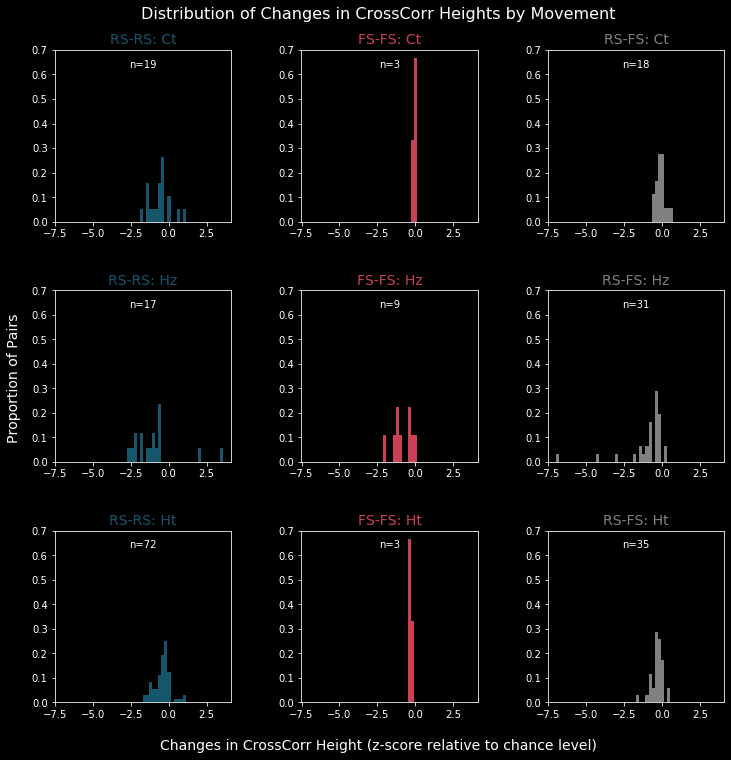

In [558]:
yMaxLim = 0.7

figCrossCompareAlertNonAlert, axCrossCorrHistsAlertNonAlert = plt.subplots(3,3,figsize=(12,12))
figCrossCompareAlertNonAlert.subplots_adjust(wspace=0.4,hspace=0.4)
figCrossCompareAlertNonAlert.suptitle("Distribution of Changes in CrossCorr Heights by Movement",\
                                      fontsize=16, y=0.93 )
xMaxLim = max(np.concatenate((np.concatenate(Ws_Ws_crossPaekChangeByArousal_AllGroups),\
                              np.concatenate(Ns_Ns_crossPaekChangeByArousal_AllGroups),\
                              np.concatenate(Ws_Ns_crossPaekChangeByArousal_AllGroups))))/chanceLevel

xMinLim = min(np.concatenate((np.concatenate(Ws_Ws_crossPaekChangeByArousal_AllGroups),\
                              np.concatenate(Ns_Ns_crossPaekChangeByArousal_AllGroups),\
                              np.concatenate(Ws_Ns_crossPaekChangeByArousal_AllGroups))))/chanceLevel

histBinSize = 0.2
histRangeDur = xMaxLim - xMinLim
binsNo = int(histRangeDur/histBinSize)

figCrossCompareAlertNonAlert.text(0.5, 0.07, 'Changes in CrossCorr Height (z-score relative to chance level)', ha='center',\
                                                        fontsize=14)
figCrossCompareAlertNonAlert.text(0.07, 0.5, 'Proportion of Pairs', va='center', rotation='vertical',fontsize=14)

groupCounter = 0
for animalTypeLoopID in ['Ct','Hz','Ht']:#uniqueAnimalTypes:
    
    Ws_Ws_crossPeak = Ws_Ws_crossPaekChangeByArousal_AllGroups[groupCounter]
    Ws_Ns_crossPeak = Ws_Ns_crossPaekChangeByArousal_AllGroups[groupCounter]
    Ns_Ns_crossPeak = Ns_Ns_crossPaekChangeByArousal_AllGroups[groupCounter]
    
    axWsWs = axCrossCorrHistsAlertNonAlert[groupCounter,0]
    axNsNs = axCrossCorrHistsAlertNonAlert[groupCounter,1]
    axWsNs = axCrossCorrHistsAlertNonAlert[groupCounter,2]
    
    groupCounter = groupCounter + 1
    
    axWsWs.hist(np.array(Ws_Ws_crossPeak)/chanceLevel,color=wideSpikingColor\
                ,weights=np.ones(len(Ws_Ws_crossPeak)) / len(Ws_Ws_crossPeak)\
               ,bins=binsNo,range=(xMinLim,xMaxLim));
    axNsNs.hist(np.array(Ns_Ns_crossPeak)/chanceLevel,color=narrowSpikingColor\
               ,weights=np.ones(len(Ns_Ns_crossPeak)) / len(Ns_Ns_crossPeak)\
               ,bins=binsNo,range=(xMinLim,xMaxLim));
    axWsNs.hist(np.array(Ws_Ns_crossPeak)/chanceLevel,color='grey'\
               ,weights=np.ones(len(Ws_Ns_crossPeak)) / len(Ws_Ns_crossPeak)\
               ,bins=binsNo,range=(xMinLim,xMaxLim));
    
#     yMaxLim = max(axWsWs.get_ylim()[1],axWsNs.get_ylim()[1],axNsNs.get_ylim()[1])
    
    axWsWs.set_ylim(top=yMaxLim)
    axWsNs.set_ylim(top=yMaxLim)
    axNsNs.set_ylim(top=yMaxLim)
    
#     xMaxLim = max(axWsWs.get_xlim()[1],axWsNs.get_xlim()[1],axNsNs.get_xlim()[1])
    
#     axWsWs.set_xlim(right=xMaxLim)
#     axWsNs.set_xlim(right=xMaxLim)
#     axNsNs.set_xlim(right=xMaxLim)
    
    axWsWs.set_title('RS-RS: '+animalTypeLoopID,color=wideSpikingColor,fontsize=14)
    axNsNs.set_title('FS-FS: '+animalTypeLoopID,color=narrowSpikingColor,fontsize=14)
    axWsNs.set_title('RS-FS: '+animalTypeLoopID,color='grey',fontsize=14)
    
    axWsWs.text((xMaxLim+xMinLim)/2,0.9*yMaxLim,'n=%(number)d'%{'number':len(Ws_Ws_crossPeak)},ha='center')
    axNsNs.text((xMaxLim+xMinLim)/2,0.9*yMaxLim,'n=%(number)d'%{'number':len(Ns_Ns_crossPeak)},ha='center')
    axWsNs.text((xMaxLim+xMinLim)/2,0.9*yMaxLim,'n=%(number)d'%{'number':len(Ws_Ns_crossPeak)},ha='center')